# Game of Zones: Using Machine Learning to Predict the Outcome of an MLB At Bat

Goal: predict where the batter is most likely to hit the ball (zones of the field) in an at-bat given the situation and the pitcher he is facing
    
Input Data: 
- the pitcher's repertoire: given that each pitcher has a different arsenal of pitches and each pitch moves differently, we use a cluster analysis to categorize pitch types.  In this way, we put each pitcher on the same footing.

- the game situation: the inning (and top/bottom), the number of outs, positions of baserunners, the count, positions of fielders(?)

- the batter's priors: distribution of batted balls into zones

Output: 
- probabilities for each zone on the field where the batter can hit the ball

- contributing factors for each prediction (things the defensive team could use to intervene)

In [159]:
from pybaseball import statcast
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline

## Build the Outcome

### Get the Hit Data from Baseball Savant

In [101]:
def get_hit_zone(start, end):
    
    # get the data from statcast
    data = statcast(start_dt=start, end_dt=end)

    # just keep the "events" (i.e., the end result of an at-bat)
    data = data[~pd.isnull(data['events'])]

    # remove events that don't involve the ball being put into play in a meaningful way 
    # (i.e., no strikeouts, walks, sacrifice bunts, caught stealing, hit by pitch, etc.)
    inplay_event_list = ['field_out', 'sac_fly', 'force_out', 'field_error', 'double', 'home_run', 
                         'grounded_into_double_play', 'fielders_choice', 'fielders_choice_out', 'triple', 
                         'double_play']
    data = data[data['events'].isin(inplay_event_list)]

    # select the columns to keep
    cols_to_keep = ['game_pk', 'index', 'batter', 'pitcher', 'events', 'hc_x', 'hc_y', 'hit_distance_sc']
    data = data[cols_to_keep]

    # make sure index columns are int's
    for col in ['game_pk', 'index', 'batter', 'pitcher']:
        data[col] = data[col].astype(int)

    # transform the hit location features such that home plate is at the origin
    data['hit_x'] = data['hc_x'].subtract(125.42)
    data['hit_y'] = data['hc_y'].multiply(-1).add(198.27)
    data.drop(['hc_x', 'hc_y'], axis=1, inplace=True)

    # use the coordinates of the hit to calculate the spray angle (in degrees)
    def spray_angle(x, y):
        return np.arctan(x/(y+0.001)) * (180 / 3.14)
    data['spray_angle'] = data.apply(lambda x: spray_angle(x.hit_x, x.hit_y), axis=1)

    # identify the zone of the hit:
    #   1 -> right side of the infield (spray angle > 0 and hit_distance < 50)
    #   2 -> left side of the infield (spray angle < 0 and hit_distance < 50)
    #   3 -> right side of the outfield (spray angle > 0 and hit_distance >= 50)
    #   4 -> left side of the outfield (spray angle < 0 and hit_distance >= 50)
    def hit_zone(angle, dist):
        if angle > 0 and dist < 50:
            return 1
        elif angle < 0 and dist < 50:
            return int(2)
        elif angle > 0 and dist >= 50:
            return 3
        elif angle < 0 and dist >= 50:
            return 4
    data['hit_zone'] = data.apply(lambda x: hit_zone(x.spray_angle, x.hit_distance_sc), axis=1)
    data = data[pd.notna(data['hit_zone'])]
    data['hit_zone'] = data['hit_zone'].astype(int)

    # return only the columns we need (index columns and the outcome "hit_zone")
    return data[['game_pk', 'index', 'batter', 'pitcher', 'hit_zone']]

In [106]:
# use Statcast data (from 2015-2018) so we can get spin rate, etc.
train_data_dates = [('2015-04-05', '2015-10-04'),
                    ('2016-04-03', '2016-10-02'),
                    ('2017-04-02', '2017-10-01'),
                    ('2018-03-29', '2018-10-01')]

# build a list of dataframes (one for each year)
train_data_list = []
for dates in train_data_dates:
    df = get_hit_zone(start=dates[0], end=dates[1])
    train_data_list.append(df)
    
# concat the list of dataframes into one large dataframe
train_data = pd.concat(train_data_list)

# write to file
data_file_path = "/home/chris/data/baseball/HitZone/"
train_data.to_csv(data_file_path + "train_4zones.csv", index=False)

print(train_data.shape)
train_data.head()

(351633, 5)


,game_pk,index,batter,pitcher,hit_zone
0,416079,242,150029,544727,4
2,416079,260,547180,544727,2
10,416079,338,543685,544727,1
15,416079,405,502517,595014,2
24,416079,523,434158,595014,4


## Build the Pitcher Data

### Get the Pitch Data from Baseball Savant

In [3]:
def get_pitch_data(start, end):
    
    data = statcast(start_dt=start, end_dt=end)
    
    print(data.columns)
    
    pitch_cols = ['pitcher', 'player_name', 'release_speed', 'release_spin_rate', 'release_extension', 
                  'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
                  'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az']

    data = data[pitch_cols]

    return data

In [3]:
# # use Statcast data (from 2015-2018) so we can get spin rate, etc.
# train_data_dates = [('2015-04-05', '2015-10-04'),
#                     ('2016-04-03', '2016-10-02'),
#                     ('2017-04-02', '2017-10-01'),
#                     ('2018-03-29', '2018-10-01')]

# # build a list of dataframes (one for each year)
# train_data_list = []
# for dates in train_data_dates:
#     df = get_pitch_data(start=dates[0], end=dates[1])
#     train_data_list.append(df)
    
# # concat the list of dataframes into one large dataframe
# train_data = pd.concat(train_data_list)

# # write to file
# data_file_path = "/home/chris/data/baseball/PitchClustering/"
# train_data.to_csv(data_file_path + "train.csv", index=False)

# read the saved dataframe
data_file_path = "/home/chris/data/baseball/PitchClustering/"
train_data = pd.read_csv(data_file_path + "train.csv")
print(train_data.shape)

# print the number of pitchers in the data set
print(f"Number of pitchers in the data: {len(train_data['pitcher'].unique())}")
      
# print the number of missing values per column
for col in train_data.columns.tolist():
    print(col, sum(pd.isnull(train_data[col])))

# drop rows with missing values
train_data.dropna(inplace=True)
print(f"Shape of training data: {train_data.shape}")

train_data.head()

(2860558, 15)
Number of pitchers in the data: 1332
pitcher 0
player_name 0
release_speed 5158
release_spin_rate 139813
release_extension 33503
pfx_x 5384
pfx_z 5384
plate_x 5428
plate_z 5428
vx0 5384
vy0 5384
vz0 5384
ax 5384
ay 5384
az 5384
Shape of training data: (2720473, 15)


,pitcher,player_name,release_speed,release_spin_rate,release_extension,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az
0,544727.0,Jeurys Familia,97.2,2018.0,6.125,-1.118083,0.455133,-0.707,2.022,3.602,-141.273,-6.540,-14.347,32.145,-28.506
1,544727.0,Jeurys Familia,97.5,2093.0,6.030,-1.108342,0.711700,0.442,3.496,6.394,-141.716,-3.746,-14.306,32.100,-24.835
2,544727.0,Jeurys Familia,98.4,1960.0,6.359,-1.523058,0.523933,-0.353,2.446,5.481,-143.007,-5.675,-20.489,36.599,-27.465
3,544727.0,Jeurys Familia,97.7,2099.0,6.275,-1.285083,0.618533,-0.054,1.273,5.577,-141.819,-8.799,-16.942,31.897,-26.150
4,544727.0,Jeurys Familia,98.2,2155.0,6.538,-0.997008,0.803433,-0.406,1.560,3.987,-142.748,-8.509,-12.709,36.274,-23.516


In [4]:
# extract the pitcherID column
pitcherID = train_data[['pitcher', 'player_name']]

train_data = train_data.drop(['pitcher', 'player_name'], axis=1)

train_data.head()

,release_speed,release_spin_rate,release_extension,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az
0,97.2,2018.0,6.125,-1.118083,0.455133,-0.707,2.022,3.602,-141.273,-6.540,-14.347,32.145,-28.506
1,97.5,2093.0,6.030,-1.108342,0.711700,0.442,3.496,6.394,-141.716,-3.746,-14.306,32.100,-24.835
2,98.4,1960.0,6.359,-1.523058,0.523933,-0.353,2.446,5.481,-143.007,-5.675,-20.489,36.599,-27.465
3,97.7,2099.0,6.275,-1.285083,0.618533,-0.054,1.273,5.577,-141.819,-8.799,-16.942,31.897,-26.150
4,98.2,2155.0,6.538,-0.997008,0.803433,-0.406,1.560,3.987,-142.748,-8.509,-12.709,36.274,-23.516


### Take a look at the data

In [5]:
train_data.describe()

,release_speed,release_spin_rate,release_extension,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az
count,2.720473e+06,2.720473e+06,2.720473e+06,2.720473e+06,2.720473e+06,2.720473e+06,2.720473e+06,2.720473e+06,2.720473e+06,2.720473e+06,2.720473e+06,2.720473e+06,2.720473e+06
mean,8.887448e+01,2.193362e+03,6.028664e+00,-2.223745e-01,8.363606e-01,-5.134785e-04,2.271332e+00,2.282423e+00,-1.291266e+02,-4.460689e+00,-2.485938e+00,2.659731e+01,-2.249097e+01
std,5.993342e+00,3.330486e+02,5.147851e-01,8.899555e-01,7.575029e-01,8.923285e-01,9.413891e-01,6.039700e+00,8.671430e+00,3.060520e+00,1.084991e+01,4.133696e+00,8.848851e+00
min,3.610000e+01,4.130000e+02,-9.160000e-01,-4.150400e+00,-4.471200e+00,-1.054330e+01,-5.183700e+00,-2.202600e+01,-1.531160e+02,-1.977060e+01,-5.929010e+01,4.312000e+00,-7.717140e+01
25%,8.490000e+01,2.056000e+03,5.690000e+00,-9.775250e-01,4.393667e-01,-5.970000e-01,1.669000e+00,-2.260900e+00,-1.356500e+02,-6.548000e+00,-1.152950e+01,2.358870e+01,-2.812000e+01
50%,9.030000e+01,2.228000e+03,6.035000e+00,-3.561000e-01,1.001100e+00,5.000000e-03,2.274000e+00,4.035000e+00,-1.312060e+02,-4.653200e+00,-3.668100e+00,2.661500e+01,-2.115360e+01
75%,9.340000e+01,2.388000e+03,6.373000e+00,5.088000e-01,1.391100e+00,6.010000e-01,2.875000e+00,6.674700e+00,-1.233828e+02,-2.547600e+00,6.005500e+00,2.947680e+01,-1.556700e+01
max,1.057000e+02,3.726000e+03,1.131000e+01,2.934450e+00,6.303600e+00,1.295290e+01,1.327190e+01,2.515000e+01,-4.973530e+01,2.187600e+01,4.097800e+01,5.405700e+01,1.697630e+01


### Rescale the Data

In [6]:
scaler = MinMaxScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data))
train_data_scaled.columns = train_data.columns

train_data_scaled.head()

,release_speed,release_spin_rate,release_extension,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az
0,0.877874,0.484455,0.575904,0.428000,0.457209,0.418634,0.390434,0.543242,0.114557,0.317687,0.448229,0.559514,0.516905
1,0.882184,0.507093,0.568133,0.429375,0.481021,0.467535,0.470302,0.602425,0.110272,0.384776,0.448638,0.558609,0.555897
2,0.895115,0.466948,0.595043,0.370839,0.463594,0.433700,0.413408,0.583072,0.097784,0.338457,0.386974,0.649050,0.527962
3,0.885057,0.508904,0.588173,0.404429,0.472374,0.446425,0.349850,0.585107,0.109276,0.263445,0.422349,0.554528,0.541929
4,0.892241,0.525807,0.609684,0.445089,0.489534,0.431444,0.365401,0.551403,0.100290,0.270409,0.464565,0.642517,0.569907


### Use PCA to Reduce Dimensionality of Data

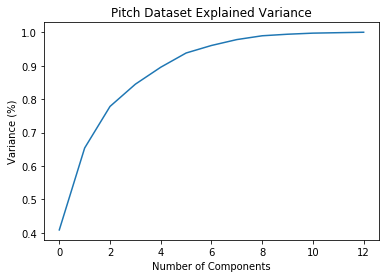

In [7]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(train_data_scaled)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pitch Dataset Explained Variance')
plt.show()

#### Fit/Transform using the number of components that get us to 98% variance explained

In [9]:
pca = PCA(n_components=7)
train_data_pca = pd.DataFrame(pca.fit_transform(train_data_scaled))
train_data_pca.head()

,0,1,2,3,4,5,6
0,26.231018,0.757541,4.503977,4.705738,-4.173192,-0.599046,-0.267557
1,8.454872,30.539815,0.237254,-3.744348,-2.174125,-5.307921,-1.525922
2,0.096342,1.100756,-0.414117,-2.737633,5.711752,5.313643,-0.371609
3,-1.743566,-3.813009,1.276004,2.168658,6.799648,0.789597,-0.179313
4,1.732545,-1.866755,-1.286800,-3.398737,0.472879,0.803258,0.457207


### K-Means Clustering of the Pitch Data

#### use the Elbow method to find optimal k

In [ ]:
# range of number of clusters
num_clusters = range(3, 16)

# initiate the models
kmeans = []
for i in num_clusters:
    print(f"initializing a model for {i} clusters")
    kmeans.append(KMeans(n_clusters=i, n_jobs=-1))

# compute the scores for each fit
score = []
for i, k in enumerate(num_clusters):
    print(f"fitting the data to {k} clusters")
    score.append(kmeans[i].fit(train_data_pca).score(train_data_pca))

# # cluster labels
# cluster_labels = []
# for i, k in enumerate(num_clusters):
#     print(f"labeling the data for {k} clusters")
#     cluster_labels.append(kmeans[i].fit_predict(train_data_pca))

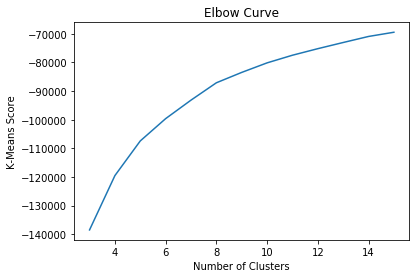

In [12]:
plt.plot(num_clusters, score)
plt.title("Elbow Curve")
plt.xlabel("Number of Clusters")
plt.ylabel("K-Means Score")
plt.show()

#### k-means with Gap statistic to find optimal k

In [10]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k, n_jobs=-1)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

k, _ = optimalK(train_data_pca)
print(f"The optimal number of clusters is: {k}")

The optimal number of clusters is: 11


#### train k-means model with optimal number of clusters

In [12]:
kmeans = KMeans(n_clusters=k, n_jobs=-1)
kmeans.fit(train_data_pca)

# build a dataframe to contain the pitch classifications
labels = pd.DataFrame(kmeans.labels_)
labels.head()

,0
0,9
1,3
2,9
3,8
4,2


#### turn the labels into counts of pitch type for each pitcher 

In [143]:
# first, one-hot-encode the label df
ohe = OneHotEncoder()
labels_ohe = pd.DataFrame(ohe.fit_transform(labels).toarray())

# give the new columns names
pitch_labels = ['pitch_type_'+str(i) for i in range(len(labels_ohe.columns.tolist()))]
labels_ohe.columns = pitch_labels

# merge the pitch type data with the pitcher's ID and name
pitch_data = pd.merge(pitcherID, labels_ohe, left_index=True, right_index=True)

# groupby on the pitcher ID/name and sum the rows
pitch_data = pitch_data.groupby(['pitcher', 'player_name']).sum()
pitch_data.reset_index(inplace=True, drop=False)

# finally, turn the pitch counts into percentages
pitch_data_pct = pd.DataFrame()
for i in range(len(pitch_data)):
    temp_df = pd.DataFrame(pitch_data.iloc[i]).T
    pitch_sum = sum(temp_df.iloc[0,2:])
    temp_df.iloc[0,2:] = temp_df.iloc[0,2:] / pitch_sum
    pitch_data_pct = pitch_data_pct.append(temp_df)
    
data_file_path = "/home/chris/data/baseball/PitchClustering/"
pitch_data_pct.to_csv(data_file_path + "pitch_11types.csv", index=False)
    
print(pitch_data_pct.shape)
pitch_data_pct.head(20)

(1323, 13)


,pitcher,player_name,pitch_type_0,pitch_type_1,pitch_type_2,pitch_type_3,pitch_type_4,pitch_type_5,pitch_type_6,pitch_type_7,pitch_type_8,pitch_type_9,pitch_type_10
0,112526,Bartolo Colon,0.15562,0.0873092,0.0812253,0.0399189,0.102039,0.0333013,0.128829,0.164585,0.0877362,0.0740741,0.0453624
1,115629,LaTroy Hawkins,0.155206,0.11002,0.0451866,0.0510806,0.0903733,0.0392927,0.113949,0.170923,0.111984,0.0628684,0.0491159
2,136600,Bruce Chen,0.117647,0.285714,0.0252101,0.00840336,0.134454,0.0504202,0.243697,0.117647,0,0.00840336,0.00840336
3,150116,Randy Wolf,0.0896552,0.0931034,0.12931,0.0275862,0.0844828,0.0637931,0.0689655,0.27069,0.0706897,0.062069,0.0396552
4,150274,Joe Nathan,0.0336134,0.176471,0.00840336,0.0252101,0.092437,0.0168067,0.327731,0.134454,0.142857,0.0336134,0.00840336
5,150302,Jason Marquis,0.112792,0.0894085,0.0660248,0.0440165,0.108666,0.0247593,0.181568,0.149931,0.0962861,0.0935351,0.0330124
6,150359,A.J. Burnett,0.197942,0.0633745,0.0679012,0.0296296,0.091358,0.0596708,0.14856,0.133333,0.111934,0.0539095,0.0423868
7,217096,Barry Zito,0.106667,0.0466667,0.0533333,0.12,0.02,0.0933333,0,0.1,0.353333,0.08,0.0266667
8,218596,Tim Hudson,0.193769,0.112773,0.0847352,0.0305296,0.0978193,0.058567,0.112773,0.148287,0.0753894,0.0579439,0.0274143
9,234194,Buddy Carlyle,0.110169,0.0423729,0.0847458,0.0932203,0.0508475,0.0338983,0.127119,0.220339,0.152542,0.0423729,0.0423729


## Build the Batter's Prior Zone Distribution

In [150]:
# use the hit zone data from the outcome calculated above
data_file_path = "/home/chris/data/baseball/HitZone/"
batter_zone_data = pd.read_csv(data_file_path + "train_4zones.csv")
batter_zone_data = batter_zone_data[['batter', 'hit_zone']]
batter_zone_data.set_index('batter', inplace=True)

# one-hot-encode the hit_zone column
ohe = OneHotEncoder()
zones_ohe = pd.DataFrame(ohe.fit_transform(batter_zone_data).toarray())
zones_ohe.index = batter_zone_data.index
zones_ohe.columns = ['zone_1', 'zone_2', 'zone_3', 'zone_4']
zones_ohe.reset_index(inplace=True, drop=False)

# group by batter ID and sum
batter_zone_data = zones_ohe.groupby('batter').sum()

# finally, turn the pitch counts into percentages
batter_zone_data_pct = pd.DataFrame()
for i in range(len(batter_zone_data)):
    temp_df = pd.DataFrame(batter_zone_data.iloc[i]).T
    pitch_sum = sum(temp_df.iloc[0,:])
    temp_df.iloc[0,:] = temp_df.iloc[0,:] / pitch_sum
    batter_zone_data_pct = batter_zone_data_pct.append(temp_df)
    
batter_zone_data_pct.reset_index(inplace=True, drop=False)
batter_zone_data_pct.columns = ['batter', 'batter_zone_1', 'batter_zone_2', 'batter_zone_3', 'batter_zone_4']

batter_zone_data_pct.to_csv("/home/chris/data/baseball/HitZone/batter_prior_4zones.csv", index=False)

print(batter_zone_data_pct.shape)
batter_zone_data_pct.head()

(1493, 5)


,batter,batter_zone_1,batter_zone_2,batter_zone_3,batter_zone_4
0,112526,0.179487,0.410256,0.230769,0.179487
1,116338,0.114094,0.278523,0.342282,0.265101
2,120074,0.253106,0.023292,0.442547,0.281056
3,121347,0.055980,0.328244,0.305344,0.310433
4,133380,0.061290,0.232258,0.367742,0.338710


In [122]:
batter_zone_data_pct.describe()

,batter,zone_1,zone_2,zone_3,zone_4
count,1493.000000,1493.000000,1493.000000,1493.000000,1493.000000
mean,539624.712659,0.213416,0.234398,0.296673,0.255513
std,81785.211549,0.209579,0.215978,0.192824,0.182343
min,112526.000000,0.000000,0.000000,0.000000,0.000000
25%,476451.000000,0.073171,0.084746,0.218391,0.142857
50%,543903.000000,0.168209,0.222222,0.318241,0.280488
75%,605228.000000,0.285714,0.300000,0.370757,0.342246
max,673633.000000,1.000000,1.000000,1.000000,1.000000


## Build the Complete Feature Set for Training the Model

### Get the Game Situation Features

In [138]:
def get_features(start, end):

    data = statcast(start_dt=start, end_dt=end)

    # just keep the "events" (i.e., the end result of an at-bat)
    data = data[~pd.isnull(data['events'])]

    # remove events that don't involve the ball being put into play in a meaningful way 
    # (i.e., no strikeouts, walks, sacrifice bunts, caught stealing, hit by pitch, etc.)
    inplay_event_list = ['field_out', 'sac_fly', 'force_out', 'field_error', 'double', 'home_run', 
                         'grounded_into_double_play', 'fielders_choice', 'fielders_choice_out', 'triple', 
                         'double_play']
    data = data[data['events'].isin(inplay_event_list)]

    # trim down the features 
    cols_to_keep = ['game_pk', 'index', 'batter', 'pitcher', 'stand', 'p_throws', 'balls', 'strikes', 'outs_when_up', 
                    'inning', 'on_1b', 'on_2b', 'on_3b', 'bat_score', 'fld_score']
    data = data[cols_to_keep]

    # make sure index columns are int's
    for col in ['game_pk', 'index', 'batter', 'pitcher']:
        data[col] = data[col].astype(int)

    data['bat_right'] = data['stand'].apply(lambda x: x == 'R') 
    data['pitch_right'] = data['p_throws'].apply(lambda x: x == 'R')
    data.drop(['stand', 'p_throws'], axis=1, inplace=True)

    for col in ['on_1b', 'on_2b', 'on_3b']:
        data[col] = data[col].apply(lambda x: x == x)

    data['score_diff'] = data['bat_score'] - data['fld_score']
    data.drop(['bat_score', 'fld_score'], axis=1, inplace=True)
    
    return data

In [141]:
# use Statcast data (from 2015-2018) so we can get spin rate, etc.
train_data_dates = [('2015-04-05', '2015-10-04'),
                    ('2016-04-03', '2016-10-02'),
                    ('2017-04-02', '2017-10-01'),
                    ('2018-03-29', '2018-10-01')]

# build a list of dataframes (one for each year)
train_data_list = []
for dates in train_data_dates:
    df = get_features(start=dates[0], end=dates[1])
    train_data_list.append(df)
    
# concat the list of dataframes into one large dataframe
train_data = pd.concat(train_data_list)

# write to file
data_file_path = "/home/chris/data/baseball/HitFeatures/"
train_data.to_csv(data_file_path + "train.csv", index=False)

print(train_data.shape)
train_data.head()

This is a large query, it may take a moment to complete
Completed sub-query from 2015-04-05 to 2015-04-10
Completed sub-query from 2015-04-11 to 2015-04-16
Completed sub-query from 2015-04-17 to 2015-04-22
Completed sub-query from 2015-04-23 to 2015-04-28
Completed sub-query from 2015-04-29 to 2015-05-04
Completed sub-query from 2015-05-05 to 2015-05-10
Completed sub-query from 2015-05-11 to 2015-05-16
Completed sub-query from 2015-05-17 to 2015-05-22
Completed sub-query from 2015-05-23 to 2015-05-28
Completed sub-query from 2015-05-29 to 2015-06-03
Completed sub-query from 2015-06-04 to 2015-06-09
Completed sub-query from 2015-06-10 to 2015-06-15
Completed sub-query from 2015-06-16 to 2015-06-21
Completed sub-query from 2015-06-22 to 2015-06-27
Completed sub-query from 2015-06-28 to 2015-07-03
Completed sub-query from 2015-07-04 to 2015-07-09
Completed sub-query from 2015-07-10 to 2015-07-15
Completed sub-query from 2015-07-16 to 2015-07-21
Completed sub-query from 2015-07-22 to 2015-

,game_pk,index,batter,pitcher,balls,strikes,outs_when_up,inning,on_1b,on_2b,on_3b,bat_right,pitch_right,score_diff
0,416079,242,150029,544727,0.0,1.0,2.0,9.0,False,True,False,True,True,-1.0
2,416079,260,547180,544727,0.0,0.0,2.0,9.0,False,False,False,False,True,-1.0
10,416079,338,543685,544727,3.0,1.0,0.0,9.0,False,False,False,True,True,-1.0
15,416079,405,502517,595014,2.0,1.0,1.0,8.0,True,False,False,False,True,1.0
24,416079,523,434158,595014,2.0,1.0,1.0,8.0,False,False,False,False,True,0.0


### Combine the Game Situation, Pitcher and Batter Features along with the Outcome

In [155]:
game_situation_df = pd.read_csv("/home/chris/data/baseball/HitFeatures/train.csv")

pitch_type_df = pd.read_csv("/home/chris/data/baseball/PitchClustering/pitch_11types.csv")

pitch_type_df.drop('player_name', axis=1, inplace=True)
pitch_type_df['pitcher'] = pitch_type_df['pitcher'].astype(int)

batter_zone_df = pd.read_csv("/home/chris/data/baseball/HitZone/batter_prior_4zones.csv")

outcome_df = pd.read_csv("/home/chris/data/baseball/HitZone/train_4zones.csv")

full_data = pd.merge(game_situation_df, pitch_type_df, on="pitcher")
full_data = pd.merge(full_data, batter_zone_df, on="batter")
full_data = pd.merge(outcome_df, full_data, on=['game_pk', 'index', 'batter', 'pitcher'])

print(game_situation_df.shape)
print(pitch_type_df.shape)
print(batter_zone_df.shape)
print(outcome_df.shape)
print(full_data.shape)
full_data.head()

(400267, 14)
(1323, 12)
(1493, 5)
(351633, 5)
(348717, 30)


,game_pk,index,batter,pitcher,hit_zone,balls,strikes,outs_when_up,inning,on_1b,...,pitch_type_5,pitch_type_6,pitch_type_7,pitch_type_8,pitch_type_9,pitch_type_10,batter_zone_1,batter_zone_2,batter_zone_3,batter_zone_4
0,416079,242,150029,544727,4,0.0,1.0,2.0,9.0,False,...,0.040259,0.137106,0.140484,0.100507,0.085867,0.041385,0.079310,0.215517,0.332759,0.372414
1,416079,260,547180,544727,2,0.0,0.0,2.0,9.0,False,...,0.040259,0.137106,0.140484,0.100507,0.085867,0.041385,0.256983,0.051210,0.363128,0.328678
2,416079,338,543685,544727,1,3.0,1.0,0.0,9.0,False,...,0.040259,0.137106,0.140484,0.100507,0.085867,0.041385,0.065395,0.198002,0.381471,0.355132
3,416079,405,502517,595014,2,2.0,1.0,1.0,8.0,True,...,0.033204,0.140337,0.149935,0.087419,0.093126,0.051362,0.202012,0.064543,0.382230,0.351215
4,416079,523,434158,595014,4,2.0,1.0,1.0,8.0,False,...,0.033204,0.140337,0.149935,0.087419,0.093126,0.051362,0.212381,0.026667,0.471429,0.289524


In [157]:
full_data = full_data.drop(['game_pk', 'index', 'batter', 'pitcher'], axis=1)

# split the dataframe into a feature set and an outcome column
X = full_data.drop('hit_zone', axis=1)
y = full_data['hit_zone']

# split the data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4256)

In [ ]:
# ----------------------
# train an XGBoost model
# ----------------------

# small set of hyperparameters to optimize over
xgb_params = {"max_depth": (3, 5, 10, 15, 20),
              "learning_rate": (0.01, 0.5, 0.1, 0.2, 0.4),
              "gamma": (0, 33, 66, 100),
              "min_child_weight": (0, 33, 66, 100),
              "colsample_bytree": (0.5, 0.75, 1),
              "subsample": (0.5, 0.75, 1),}

# perform the paramater grid search using 5-fold cross validation
xgb_opt = GridSearchCV(XGBClassifier(objective='multi:softprob', num_class=4), 
                       param_grid=xgb_params, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

#xgb_opt = XGBClassifier(objective='multi:softprob', num_class=4)

# perform fit and make predictions
xgb_opt.fit(X_train, y_train)
y_pred = xgb_opt.predict(X_test)
y_prob = xgb_opt.predict_proba(X_test)

# compute accuracy
accuracy = round(accuracy_score(y_test, y_pred) * 100, 1)

# print the confusion matrix
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5 
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5 
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5 
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5 
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5 
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75 
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75 
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5, total= 2.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5 


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.2min
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5, total= 2.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5, total= 4.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5, total= 4.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1, total= 3.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1, total= 3.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1, total= 3.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5, total= 4.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5, total= 4.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5, total= 4.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1, total= 3.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1, total= 3.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1, total= 3.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1, total= 3.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5, total= 8.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5, total= 8.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5, total= 8.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5, total= 8.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75, total= 7.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75, total= 8.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5, total= 8.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75, total= 8.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75, total= 7.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75, total= 7.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5 


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 80.1min
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5, total= 7.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5, total=12.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5, total=12.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5, total=11.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5, total=12.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75, total=11.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75, total=11.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5, total=11.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75, total=11.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75, total=11.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1, total=11.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75, total=12.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1, total=11.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5, total=10.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1, total=11.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1, total=11.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1, total=11.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5, total=10.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5, total=10.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5, total=10.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.75, total=11.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.75, total=10.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.75, total=10.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.75, total=11.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=1, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.75, total=11.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=1, total=10.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=1, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.5, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.5, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=1, total=10.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=1, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.5, total=10.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.5, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.5, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.75, total=10.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.75, total=10.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.75, total=10.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.75, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=0.75, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=1, total=10.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=1, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=1, total=10.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=1, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.5, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.5, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.5, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=66, subsample=1, total=10.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.5, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.5, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.75, total=10.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.75, total=10.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.75, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.75, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=0.75, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=1, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=1, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=1, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=1, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=100, subsample=1, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.5, total=17.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.5, total=17.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.5, total=17.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.5, total=17.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.5, total=17.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.75, total=17.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.75, total=17.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.75, total=17.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.75, total=17.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=0.75, total=17.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=1, total=17.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=1, total=17.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.5, total=13.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=1, total=17.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=1, total=17.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=0, subsample=1, total=17.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.5, total=13.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.5, total=13.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.5, total=13.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.5, total=14.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.75, total=15.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.75, total=16.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.75, total=16.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.75, total=16.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=1, total=16.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=0.75, total=16.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=1, total=16.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=1, total=15.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.5, total=12.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=1, total=15.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.5, total=12.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=33, subsample=1, total=15.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.5, total=12.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.5, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.5, total=12.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.75, total=14.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.75, total=13.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.75, total=13.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.75, total=13.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=0.75, total=13.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=1, total=13.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=1, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=1, total=13.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=1, total=14.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.5, total=11.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.5, total=12.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=66, subsample=1, total=14.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.5, total=12.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.5, total=12.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.5, total=12.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.75, total=12.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.75, total=13.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.75, total=13.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.75, total=13.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=0.75, total=13.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=1, total=13.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=1, total=12.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=1, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=1, total=12.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=1, total= 1.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=33, subsample=1, total= 1.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=20, min_child_weight=100, subsample=1, total=12.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.75, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=0.75, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=1, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=1, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=66, subsample=1, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.5, total= 2.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.5, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.5, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.5, total= 2.3min


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=1 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.5, total= 2.3min


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 347.2min


[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.75, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=0.75, total= 2.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=3, min_child_weight=100, subsample=1, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=1, total= 3.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=0, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.8min


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=1 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=33, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=66, subsample=1, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.75, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.75, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.75, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.75, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=0.75, total= 7.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=0, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=1, total= 6.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=1, total= 6.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=33, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=1, total= 6.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=1, total= 6.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=1, total= 6.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=1, total= 6.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=66, subsample=1, total= 6.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.5, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=1, total= 5.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=1, total= 5.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=1, total= 6.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=1, total= 5.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=10, min_child_weight=100, subsample=1, total= 5.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.5, total=12.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.5, total=12.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.5, total=12.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.5, total=12.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.5, total=11.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.75, total=11.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.75, total=11.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.75, total=11.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.75, total=11.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=1, total=11.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=1, total=11.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=0.75, total=12.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.5, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=1, total=11.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=1, total=11.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=0, subsample=1, total=11.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.5, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.5, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.5, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.5, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.75, total=10.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.75, total=10.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.75, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.75, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=1, total= 9.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=1, total= 9.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=0.75, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=1, total= 9.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=1, total= 9.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=33, subsample=1, total= 9.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.5, total=10.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.5, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.5, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.5, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.5, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.75, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.75, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.75, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.75, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=0.75, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=1, total= 9.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=1, total= 9.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=1, total= 9.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=1, total= 9.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=66, subsample=1, total= 9.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.5, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.5, total=10.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.5, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.5, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.5, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.75, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.75, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.75, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=1, total= 9.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.75, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=0.75, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=1, total= 9.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=1, total= 9.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=1, total= 8.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=15, min_child_weight=100, subsample=1, total= 9.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.5, total=17.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.5, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.5, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.5, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.5, total=16.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.75, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.75, total=17.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.75, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.75, total=17.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=0.75, total=17.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.5, total=13.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=1, total=17.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=1, total=17.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=1, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=1, total=17.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=0, subsample=1, total=17.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.5, total=13.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.5, total=13.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.5, total=13.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.5, total=13.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.75, total=14.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.75, total=14.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.75, total=14.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.75, total=14.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=1, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=1, total=12.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=0.75, total=14.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=1, total=13.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=1, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=33, subsample=1, total=13.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.5, total=13.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.5, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.5, total=13.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.5, total=13.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.5, total=13.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.75, total=13.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.75, total=14.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.75, total=14.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.75, total=13.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=0.75, total=13.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=1, total=12.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=1, total=12.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=1, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=1, total=12.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=66, subsample=1, total=13.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.5, total=13.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.5, total=13.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.5, total=13.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.5, total=12.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.5, total=12.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.75, total=13.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.75, total=13.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.75, total=13.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=1, total=12.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.75, total=13.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=0.75, total=13.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=1, total=12.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=1, total=12.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=1, total=12.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_depth=20, min_child_weight=100, subsample=1, total=11.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.75 


[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 659.7min
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=66, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=100, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=1, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=1, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=0, subsample=1, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=33, subsample=1, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=66, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.75, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.75, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.75, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.75, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=1, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=1, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=0.75, total= 7.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0, subsample=1, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=1, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=1, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=1, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=33, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.5, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=1, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=66, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=1, total= 6.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=100, subsample=1, total= 6.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.5, total=13.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.5, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.5, total=13.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.5, total=13.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.5, total=14.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.75, total=14.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.75, total=14.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.75, total=14.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.75, total=12.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=0.75, total=12.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=1, total=11.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=1, total=11.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.5, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=1, total=11.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=1, total=11.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=0, subsample=1, total=11.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.5, total=10.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.5, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.5, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.5, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.75, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.75, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.75, total=10.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.75, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=0.75, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=1, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=1, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=1, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=1, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=33, subsample=1, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.5, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.5, total=10.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.5, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.5, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.5, total=10.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.75, total=10.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.75, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.75, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.75, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=0.75, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=1, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=1, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=1, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=1, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=66, subsample=1, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.5, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.5, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.5, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.5, total= 9.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.5, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.75, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.75, total=10.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.75, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.75, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=1, total= 9.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=0.75, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=1, total= 9.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=1, total= 9.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=1, total= 9.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=15, min_child_weight=100, subsample=1, total= 9.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.5, total=17.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.5, total=17.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.5, total=17.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.5, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.5, total=16.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.75, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.75, total=17.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.75, total=17.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.75, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=0.75, total=17.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=1, total=17.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=1, total=17.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.5, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=1, total=17.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=1, total=17.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=0, subsample=1, total=17.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.5, total=13.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.5, total=13.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.5, total=14.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.5, total=13.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.75, total=14.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.75, total=14.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.75, total=14.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.75, total=14.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=1, total=13.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=1, total=13.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=0.75, total=14.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=1, total=13.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=1, total=14.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.5, total=13.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=33, subsample=1, total=14.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.5, total=13.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.5, total=13.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.5, total=13.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.5, total=13.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.75, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.75, total=14.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.75, total=13.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.75, total=13.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=0.75, total=14.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=1, total=13.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=1, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=1, total=13.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=1, total=13.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.5, total=13.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=66, subsample=1, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.5, total=13.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.5, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.5, total=13.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.5, total=12.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.75, total=13.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.75, total=14.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.75, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.75, total=13.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=1, total=13.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=0.75, total=13.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=1, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=1, total=13.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=1, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=100, subsample=1, total=12.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=66, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=100, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=1, total= 2.8min


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.5 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=1, total= 2.8min


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.75 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=33, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=1 


[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 1002.2min
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=66, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.75, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.75, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.75, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.5, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.75, total= 7.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=1, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=0.75, total= 7.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=1, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=0, subsample=1, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=1, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=0.75, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=1, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=33, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.5, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.5, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=1, total= 6.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=66, subsample=1, total= 6.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.5, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.5, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=1, total= 6.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=1, total= 6.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=1, total= 5.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=1, total= 6.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=100, subsample=1, total= 6.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.5, total=12.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.5, total=12.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.5, total=12.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.5, total=12.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.75, total=11.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.5, total=11.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.75, total=11.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.75, total=11.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.75, total=11.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=1, total=11.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=1, total=11.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=0.75, total=11.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.5, total=10.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=1, total=11.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=1, total=11.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=0, subsample=1, total=11.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.5, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.5, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.5, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.5, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.75, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.75, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.75, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.75, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=1, total= 9.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=0.75, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=1, total= 9.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=1, total= 9.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=1, total= 9.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=33, subsample=1, total= 9.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.5, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.5, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.5, total=10.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.5, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.5, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.75, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.75, total=10.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.75, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.75, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=0.75, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=1, total= 9.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=1, total= 9.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=1, total= 9.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=1, total= 9.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=66, subsample=1, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.5, total=10.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.5, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.5, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.5, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.5, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.75, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.75, total=10.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.75, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=1, total= 9.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.75, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=0.75, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=1, total= 9.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=1, total= 9.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=1, total= 9.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=100, subsample=1, total= 9.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.5, total=17.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.5, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.5, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.5, total=17.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.5, total=17.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.75, total=17.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.75, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.75, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.75, total=17.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=0.75, total=17.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.5, total=13.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=1, total=17.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=1, total=17.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=1, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=1, total=17.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=0, subsample=1, total=17.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.5, total=13.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.5, total=13.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.5, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.5, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.75, total=14.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.75, total=14.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.75, total=14.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.75, total=14.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=1, total=13.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=1, total=13.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=0.75, total=14.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=1, total=13.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=1, total=13.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=33, subsample=1, total=13.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.5, total=13.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.5, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.5, total=13.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.5, total=13.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.5, total=13.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.75, total=13.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.75, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.75, total=13.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.75, total=13.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=0.75, total=13.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=1, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=1, total=12.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=1, total=12.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=1, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=66, subsample=1, total=13.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.5, total=13.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.5, total=13.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.5, total=13.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.5, total=12.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.5, total=12.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.75, total=13.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.75, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.75, total=13.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.75, total=13.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=0.75, total=13.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=1, total=12.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.75, total= 2.0min
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.75 
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=1, total=12.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=1, total=12.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=0, subsample=1, total= 1.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=1, total=12.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=20, min_child_weight=100, subsample=1, total=11.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=66, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=1, total= 1.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=1 
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0, subsample=1, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=66, subsample=1, total= 3.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.5, total= 4.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=1, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=1, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=1, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=1, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=100, subsample=1, total= 3.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.5, total= 9.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.5, total= 8.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.5, total= 8.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.5, total= 9.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.75, total= 8.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.75, total= 8.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.75, total= 8.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.5, total= 8.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.75, total= 8.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=1, total= 7.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=0.75, total= 8.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=1, total= 7.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=1, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=1, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=0, subsample=1, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=1, total= 6.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=33, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=1, total= 6.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=1, total= 6.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=1, total= 6.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=66, subsample=1, total= 6.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.5, total= 7.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.5, total= 7.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=1, total= 5.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=1, total= 5.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=1, total= 5.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=1, total= 5.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=10, min_child_weight=100, subsample=1, total= 5.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.5, total=12.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.5, total=12.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.5, total=12.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.5, total=12.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.75, total=11.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.5, total=11.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.75, total=11.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.75, total=11.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.75, total=12.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=0.75, total=11.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=1, total=11.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=1, total=11.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.5, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=1, total=11.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=1, total=11.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=0, subsample=1, total=11.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.5, total=12.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.5, total=12.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.5, total=12.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.5, total=12.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.75, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.75, total=12.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.75, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.75, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=1, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=1, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=1, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=0.75, total=11.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=1, total= 9.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=33, subsample=1, total= 9.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.5, total=10.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.5, total=10.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.5, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.5, total=10.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.5, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.75, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.75, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.75, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.75, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=0.75, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=1, total= 9.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=1, total= 9.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=1, total= 9.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=1, total= 9.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=66, subsample=1, total= 9.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.5, total=10.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.5, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.5, total=10.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.5, total= 9.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.5, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.75, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.75, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.75, total=10.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.75, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=1, total= 9.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=0.75, total=10.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=1, total= 8.8min


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=1, total= 8.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=1, total= 8.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=15, min_child_weight=100, subsample=1, total= 8.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.5, total=17.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.5, total=17.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.75 


[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 1498.9min
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.5, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.5, total=17.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.5, total=17.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.75, total=17.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.75, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.75, total=17.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.75, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=0.75, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=1, total=17.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.5, total=13.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=1, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=1, total=17.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=1, total=17.5min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=0, subsample=1, total=17.4min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.5, total=13.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.5, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.5, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.5, total=14.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.75, total=14.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.75, total=14.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.75, total=14.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.75, total=14.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=1, total=12.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=1, total=12.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=0.75, total=14.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=1, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=1, total=13.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=33, subsample=1, total=13.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.5, total=13.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.5, total=13.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.5, total=13.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.5, total=13.3min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.5, total=13.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.75, total=13.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.75, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.75, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.75, total=13.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=0.75, total=13.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=1, total=12.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=1, total=13.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=1, total=12.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=1, total=13.0min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=66, subsample=1, total=12.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.5, total=12.9min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.5, total=13.2min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.5, total=13.1min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.5, total=12.8min


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.5, total=12.7min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.75, total=13.6min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.75, total=13.8min
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.75, total=13.5min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=1, total=12.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.75, total=13.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=0.75, total=13.4min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.5, total= 2.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1, total= 1.5min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=1, total=12.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=1, total=12.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=0, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=1, total=11.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_depth=20, min_child_weight=100, subsample=1, total=11.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1, total= 1.5min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=33, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=66, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.5, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=0.75, total= 1.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=3, min_child_weight=100, subsample=1, total= 1.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1, total= 3.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=0, subsample=1, total= 3.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=33, subsample=1, total= 3.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.5, total= 3.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=0.75, total= 3.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=66, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.5, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=0.75, total= 3.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1, total= 2.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=5, min_child_weight=100, subsample=1, total= 2.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5, total= 8.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5, total= 8.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5, total= 8.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5, total= 8.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75, total= 9.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.5, total= 9.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75, total= 9.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75, total= 8.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75, total= 8.4min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1, total= 7.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1, total= 7.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=0.75, total= 8.4min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1, total= 7.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1, total= 7.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=0, subsample=1, total= 7.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5, total= 8.5min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5, total= 8.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.5, total= 7.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75, total= 7.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75, total= 7.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75, total= 7.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75, total= 7.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=33, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=0.75, total= 6.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1, total= 6.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1, total= 6.5min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=66, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5, total= 7.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.5, total= 6.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.9min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75, total= 6.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1, total= 6.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=0.75, total= 7.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1, total= 6.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1, total= 6.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=10, min_child_weight=100, subsample=1, total= 6.4min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5, total=11.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5, total=11.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5, total=11.2min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5, total=11.3min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.5, total=11.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75, total=10.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75, total=10.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75, total=11.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75, total=11.1min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1, total=10.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=0.75, total=11.0min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1, total=10.8min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1, total=10.7min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1, total=10.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=0, subsample=1, total=10.6min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.75 


/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/chris/.virtualenv/closedloop/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.5, total=10.5min
[CV] colsample_bytree=0.5, gamma=33, learning_rate=0.01, max_depth=15, min_child_weight=33, subsample=0.75 


In [ ]:
accuracy

In [ ]:
features = X_train.columns.tolist()
importances = list(xgb_opt.feature_importances_)
for i in range(len(features)):
    print(features[i] + "\t" + str(importances[i] * 100.))